# Akbank Derin Öğrenme Proje -  Intel Görüntü Sınıflandırması

Proje adımları şu şekildedir; 
1.  Geliştirme Ortamı Kurulumu ve Proje Tanıtımı
* 1.1 Başlık ve Giriş
* 1.2 Gerekli kütüphanelerin Yüklenmesi
* 1.3 Veri Seti Yolu Tanımlanması
2. Veri Ön İşleme ve Görselleştirilmesi
* 2.1 Sınıf Dağılımının Görselleştirilmesi
* 2.2 Veri Çoğaltma (Data Augmentation) ve Ön İşleme
* 2.3 Örnek Görüntüler
3. Modelin Eğitilmesi
* 3.1 CNN Model Mimarisi Oluşturma
* 3.2 Modeli Derleme
* 3.3 Geri Çağırım Tanımlama
* 3.4 Modeli Eğitme
4. Modelin Değerlendirilmesi
* 4.1 Accuracy ve Loss Grafikleri
* 4.2 Confusion Matrix ve Classification Raporları
* 4.3 Grad ve CAM Görüntüleri
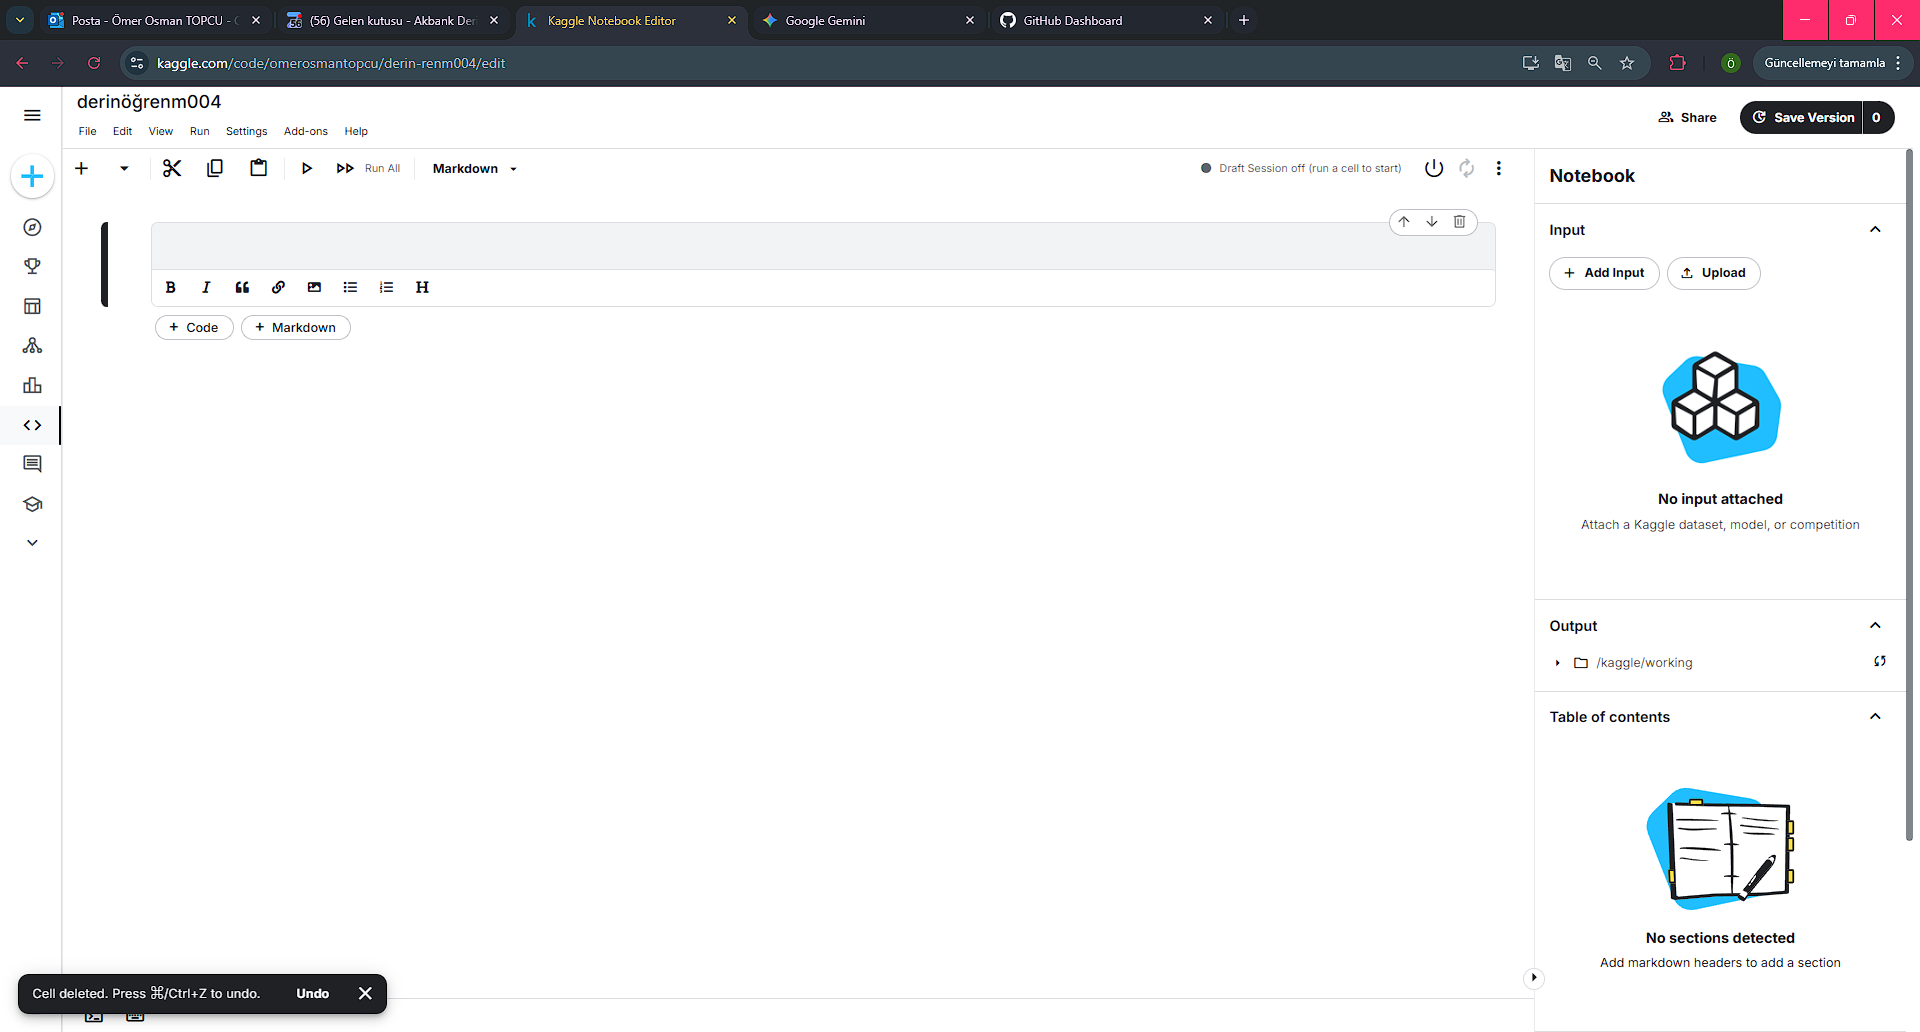

# 1. Geliştirme Ortamı Kurulumu ve Proje Tanıtımı

## 1.1 Başlık ve Giriş

Bu proje, Intel Image Classification veri setini kullanarak 6 farklı doğal ve yapay ortamı (Buildings, Forest, Glacier, Mountain, Sea, Street) sınıflandırmak için bir CNN (Convolutional Neural Network) modeli geliştirmeyi amaçlamaktadır. 

## 1.2 Gerekli Kütüphanelerin Yüklenmesi
Proje boyunca geliştirme, eğitim ve analiz süreçleri için TensorFlow/Keras temel derin öğrenme olarak kullanılmıştır. Sayısal işlemler ve veri manipülasyonu NumPy ile gerçekleştirilirken, model performansının ve Grad-CAM sonuçlarının görselleştirilmesi için Matplotlib tercih edilmiştir. Modelin değerlendirme metrikleri (classification_report ve confusion_matrix) scikit-learn kütüphanesi aracılığıyla hesaplanmıştır. Ayrıca, Grad-CAM görselleştirmesinde heatmap ile orijinal görüntünün birleştirilmesi gibi kritik görüntü işleme operasyonları için OpenCV (cv2) kullanılmıştır.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("Kütüphaneler yüklendi ve içe aktarıldı.")

E0000 00:00:1758912422.974299      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758912423.070948      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Kütüphaneler yüklendi ve içe aktarıldı.


## 1.3 Veri Seti Yolu Tanımlaması
Bu aşamada verilerin sınıflara ayrıldığı bilgisi edinilir. Veri yapısını tanımlamak ve veriyi anlamak için bu adım önemlidir.

In [2]:
base_dir = '/kaggle/input/intel-image-classification/'
train_dir = os.path.join(base_dir, 'seg_train/seg_train')
test_dir = os.path.join(base_dir, 'seg_test/seg_test')

classes = os.listdir(train_dir)
print("Sınıf İsimleri (6 Sınıf):", classes)

Sınıf İsimleri (6 Sınıf): ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


# 2. Veri Ön İşleme ve Görselleştirme

 Veri önişleme adımında, görüntüler öncelikle uygun formata dönüştürülmüş, etiketlenmiş ve train-validation-test setlerine ayrılmıştır. Bu süreçte temel olarak tf.keras.preprocessing.image.ImageDataGenerator kullanılmıştır. Görüntü piksel değerleri rescale=1./255 ile normalize edilerek modelin öğrenme süreci hızlandırılmıştır. Ayrıca, modelin genelleme yeteneğini artırmak ve Overfitting'i azaltmak amacıyla Data Augmentation (Veri Çoğaltma) teknikleri (rotation_range, width_shift, zoom_range) uygulanmıştır. Tüm görüntüler, modelin girdi katmanına uygun olarak target_size=(128, 128) piksel boyutuna yeniden boyutlandırılmıştır.

## 2.1 Sınıf Dağılımının Görselleştirilmesi
Bu adımda her sınıfta kaçar tane veriye sahip olduğumuzu daha net görebilmek için sütun grafiği ile görselleştirilme yapılmıştır. Bu aşama da aynı şekilde verimizi anlamak için önemli adımlardan biridir. Verileri görselleştirmek analiz yapmamız için daha kolay bir ortam hazırlar. 

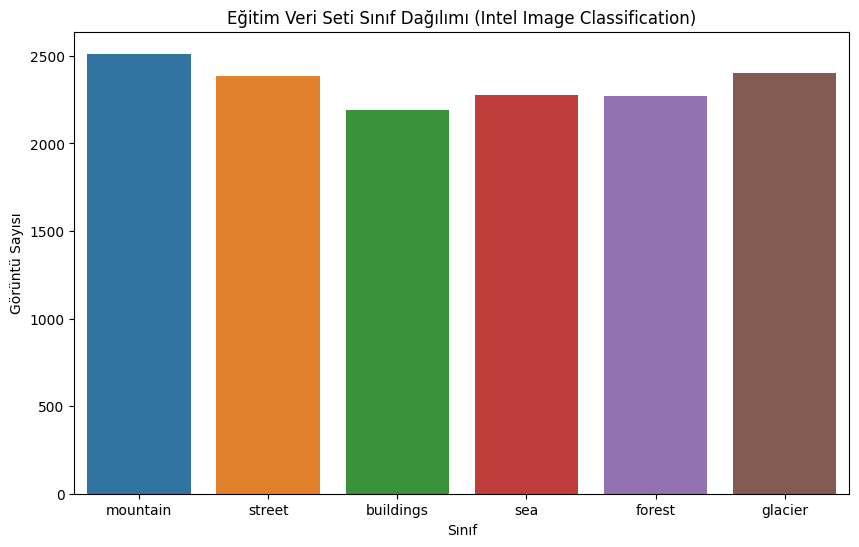

In [3]:
class_counts = {}
for name in classes:
    class_counts[name] = len(os.listdir(os.path.join(train_dir, name)))

df = pd.DataFrame(class_counts.items(), columns=['Sınıf', 'Görüntü Sayısı'])

plt.figure(figsize=(10, 6))
sns.barplot(x='Sınıf', y='Görüntü Sayısı', data=df)
plt.title('Eğitim Veri Seti Sınıf Dağılımı (Intel Image Classification)')
plt.show()

## 2.2 Veri Çoğaltma (Data Augmentation) ve Ön İşleme

Veri önişleme adımında, görüntüler öncelikle uygun formata dönüştürülmüş, etiketlenmiş ve "train-validation-test" setlerine ayrılmıştır. Bu süreçte temel olarak "tf.keras.preprocessing.image.ImageDataGenerator" kullanılmıştır. Görüntü piksel değerleri "rescale=1./255" ile normalize edilerek modelin öğrenme süreci hızlandırılmış ve kararlılığı artırılmıştır. Ayrıca, modelin genelleme yeteneğini artırmak ve Overfitting'i azaltmak amacıyla Data Augmentation (Veri Çoğaltma) teknikleri (rotation_range, width_shift, zoom_range) uygulanmıştır. Tüm görüntüler, modelin girdi katmanına uygun olarak target_size=(128, 128) piksel boyutuna yeniden boyutlandırılmıştır.

In [4]:
IMG_SIZE = (128, 128) 
BATCH_SIZE = 64

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.2,
    
    rotation_range=20,
    width_shift_range=0.1, 
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test Veri Akışını Oluşturma
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False 
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 2.3 Örnek Görüntüler
Bu adımda verileri daha net anlamak için her sınıftan birer tane örnek görüntü görüntülenmiştir.

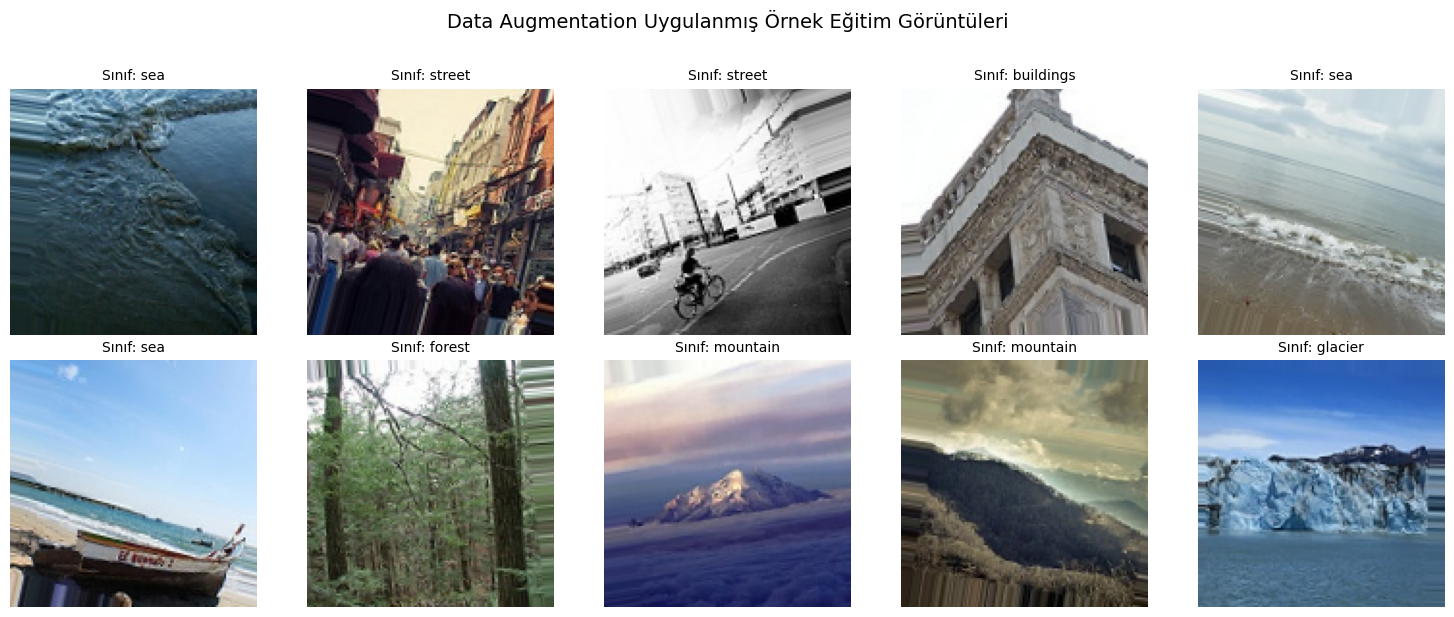

In [5]:
sample_batch = next(train_generator)
images, labels = sample_batch

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

class_names = list(train_generator.class_indices.keys())

for i in range(10):
    ax = axes[i]
    ax.imshow(images[i]) 

    label_index = np.argmax(labels[i])
    ax.set_title(f"Sınıf: {class_names[label_index]}", fontsize=10)
    ax.axis('off')

plt.suptitle('Data Augmentation Uygulanmış Örnek Eğitim Görüntüleri', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# 3. Modelin Eğitilmesi
 Proje gereksinimlerine uygun olarak "tf.keras.models.Sequential" ile temel bir CNN mimarisi oluşturulmuştur. Modelin temel bileşenleri Conv2D (öznitelik çıkarımı), MaxPooling2D (boyut indirgeme) ve BatchNormalization (öğrenme kararlılığı) katmanlarından oluşmuştur. Overfitting riskini en aza indirmek amacıyla tam bağlantılı katmanlara Dropout (Dropout(0.4), Dropout(0.2)) uygulanmıştır. Son katmanda 6 sınıf için Softmax aktivasyonu (Dense(6, activation='softmax')) kullanılarak her sınıf için olasılık dağılımı çıktısı alınmıştır. Model, optimizer='adam' ve çok sınıflı bir problem olduğu için loss='categorical_crossentropy' kullanılarak derlenmiştir.

## 3.1 CNN Model Mimarisi Oluşturma

In [6]:
IMG_SIZE = (128, 128)
NUM_CLASSES = len(classes)

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    
    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.4),
    
    Dense(256, activation='relu'),
    Dropout(0.2),
    
    Dense(NUM_CLASSES, activation='softmax') # 6 sınıflı Multi-Class için Softmax [cite: 34]
])
model.summary()


I0000 00:00:1758912445.174298      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758912445.175002      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,072,582 (49.87 MB)

 Trainable params: 13,072,134 (49.87 MB)

 Non-trainable params: 448 (1.75 KB)

## 3.2 Modeli Derleme
Learning rate = 0.0005 olarak belirlenir. 

In [7]:
from tensorflow.keras.optimizers import Adam
LEARNING_RATE = 0.0005

model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

## 3.3 Geri Çağrım (Callbacks) Tanımlama
Bu aşamada overfittingi önlemek için erken durdurma ve modelin en optimum çıktısını saklamak için gerekli kodlar yazılmıştır. Patience = 10 olarak alınmıştır. Eğer 10 adım boyunca bir iyileşme göstermezse model kendini durduracaktır.

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='best_cnn_model.keras',
        monitor='val_accuracy',
        save_best_only=True
    )
]

## 3.4 Modeli Eğitme
Epoch 20 olarak alınmştır ve model eğitme işlemi bu adımda gerçekleştirilmiştir. 

In [9]:
EPOCHS = 20

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=callbacks
)

Epoch 1/20


I0000 00:00:1758912452.574847      86 service.cc:148] XLA service 0x7890a00157a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758912452.576422      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758912452.576447      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758912453.155544      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/175 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.1445 - loss: 4.7083  

I0000 00:00:1758912459.060874      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 ━━━━━━━━━━━━━━━━━━━━ 124s 646ms/step - accuracy: 0.4486 - loss: 2.9189 - val_accuracy: 0.2169 - val_loss: 4.8796
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.4844 - loss: 1.2266 - val_accuracy: 0.2155 - val_loss: 4.8601
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 349ms/step - accuracy: 0.5882 - loss: 1.1505 - val_accuracy: 0.3347 - val_loss: 3.5877
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6094 - loss: 1.2143 - val_accuracy: 0.3307 - val_loss: 3.5200
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 348ms/step - accuracy: 0.6486 - loss: 0.9887 - val_accuracy: 0.6166 - val_loss: 1.1437
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.6406 - loss: 0.9063 - val_accuracy: 0.5970 - val_loss: 1.1839
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 61s 348ms/step - accuracy: 0.6843 - loss: 0.8775 - val_accuracy: 0.6973 - val_loss: 0.7987
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.6875 - loss: 0.7964 - val_ac

# 4. Modelin Değerlendirilmesi
Eğitim bittikten sonra modelin değerlendirilmesi için bazı metriklerin kontrol edilmesi ve görselleştirilmesi gerekmektedir. 

## 4.1. Accuracy ve Loss Grafikleri
Bu aşamada eğitim ve test aşamalarında model performansının nasıl değiştiği, her epoch sonrası değerlerin nasıl geliştiğini incelemek için grafikler oluşturulur. 

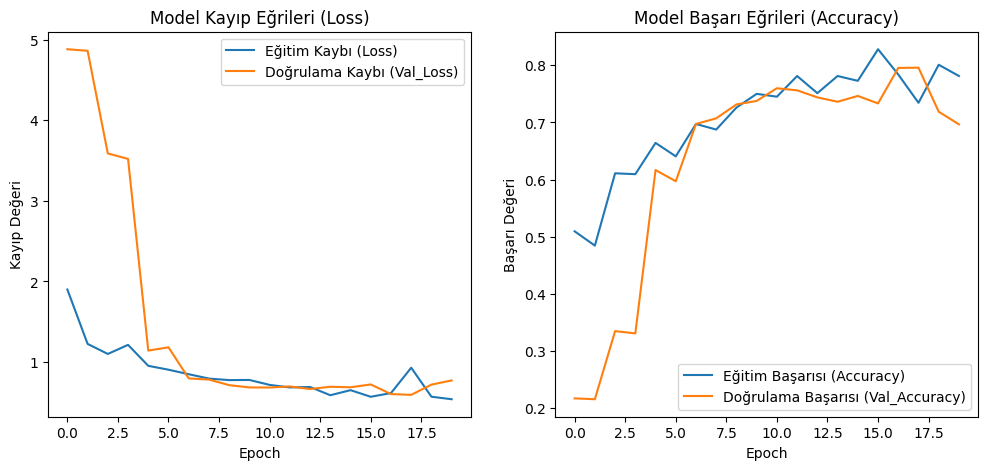

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Eğitim Kaybı (Loss)')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı (Val_Loss)')
plt.title('Model Kayıp Eğrileri (Loss)')
plt.ylabel('Kayıp Değeri')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Eğitim Başarısı (Accuracy)')
plt.plot(history.history['val_accuracy'], label='Doğrulama Başarısı (Val_Accuracy)')
plt.title('Model Başarı Eğrileri (Accuracy)')
plt.ylabel('Başarı Değeri')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## 4.2. Confusion Matrix ve Classification Report
Bu aşamada modelin görmediği test verileri üzerine matris ve diğer raporlamalar oluşturulur. 

Test seti üzerinde tahminler yapılıyor...
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step


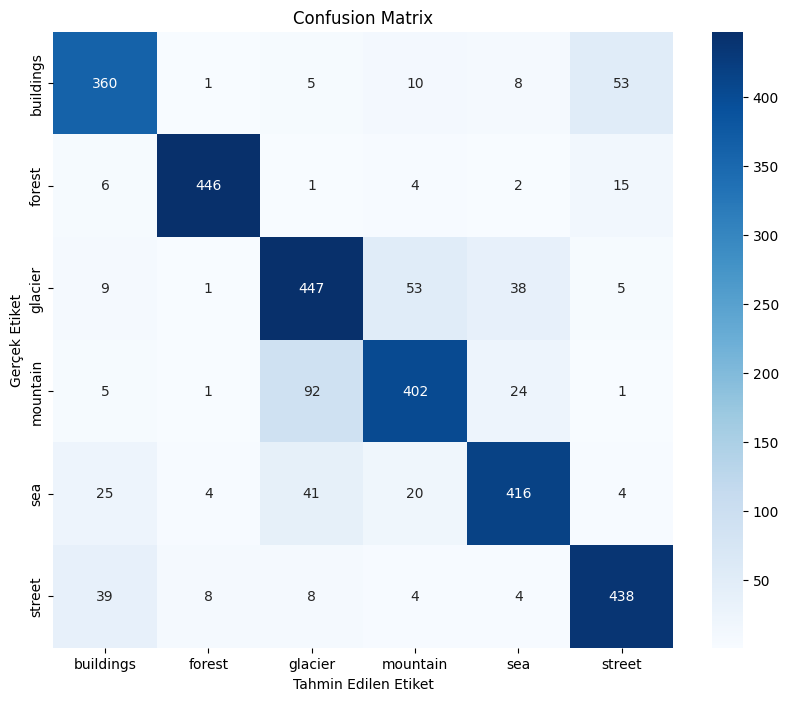


Classification Report:
              precision    recall  f1-score   support

   buildings       0.81      0.82      0.82       437
      forest       0.97      0.94      0.95       474
     glacier       0.75      0.81      0.78       553
    mountain       0.82      0.77      0.79       525
         sea       0.85      0.82      0.83       510
      street       0.85      0.87      0.86       501

    accuracy                           0.84      3000
   macro avg       0.84      0.84      0.84      3000
weighted avg       0.84      0.84      0.84      3000



In [11]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

best_model = tf.keras.models.load_model('best_cnn_model.keras')

print("Test seti üzerinde tahminler yapılıyor...")
steps = test_generator.samples // test_generator.batch_size + 1 
Y_pred = best_model.predict(test_generator, steps=steps)

y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes 

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## 4.3 Grad-CAM 
Grad-CAM (Gradient-weighted Class Activation Mapping), bir derin öğrenme modelinin yorumlanabilirliğini sağlamak için kullanılan kritik bir görselleştirme tekniğidir. Temel amaç, modelin bir tahmini yaparken görüntünün hangi bölgelerine odaklandığını göstermek ve böylece modelin kararlarını şeffaf hale getirmektir. Bu teknik, modelin doğru tahmin yapsa bile mantıklı kanıtları mı kullandığını kontrol etmemizi ve hataları analiz etmemizi sağlar. Bu aşamada Grad-CAM kodlamaları yapılmıştır ve sonuçlar incelenmiştir.

Orijinal model yüklendi ve ağırlıklar alındı.
Model ağırlıkları yüklendi.


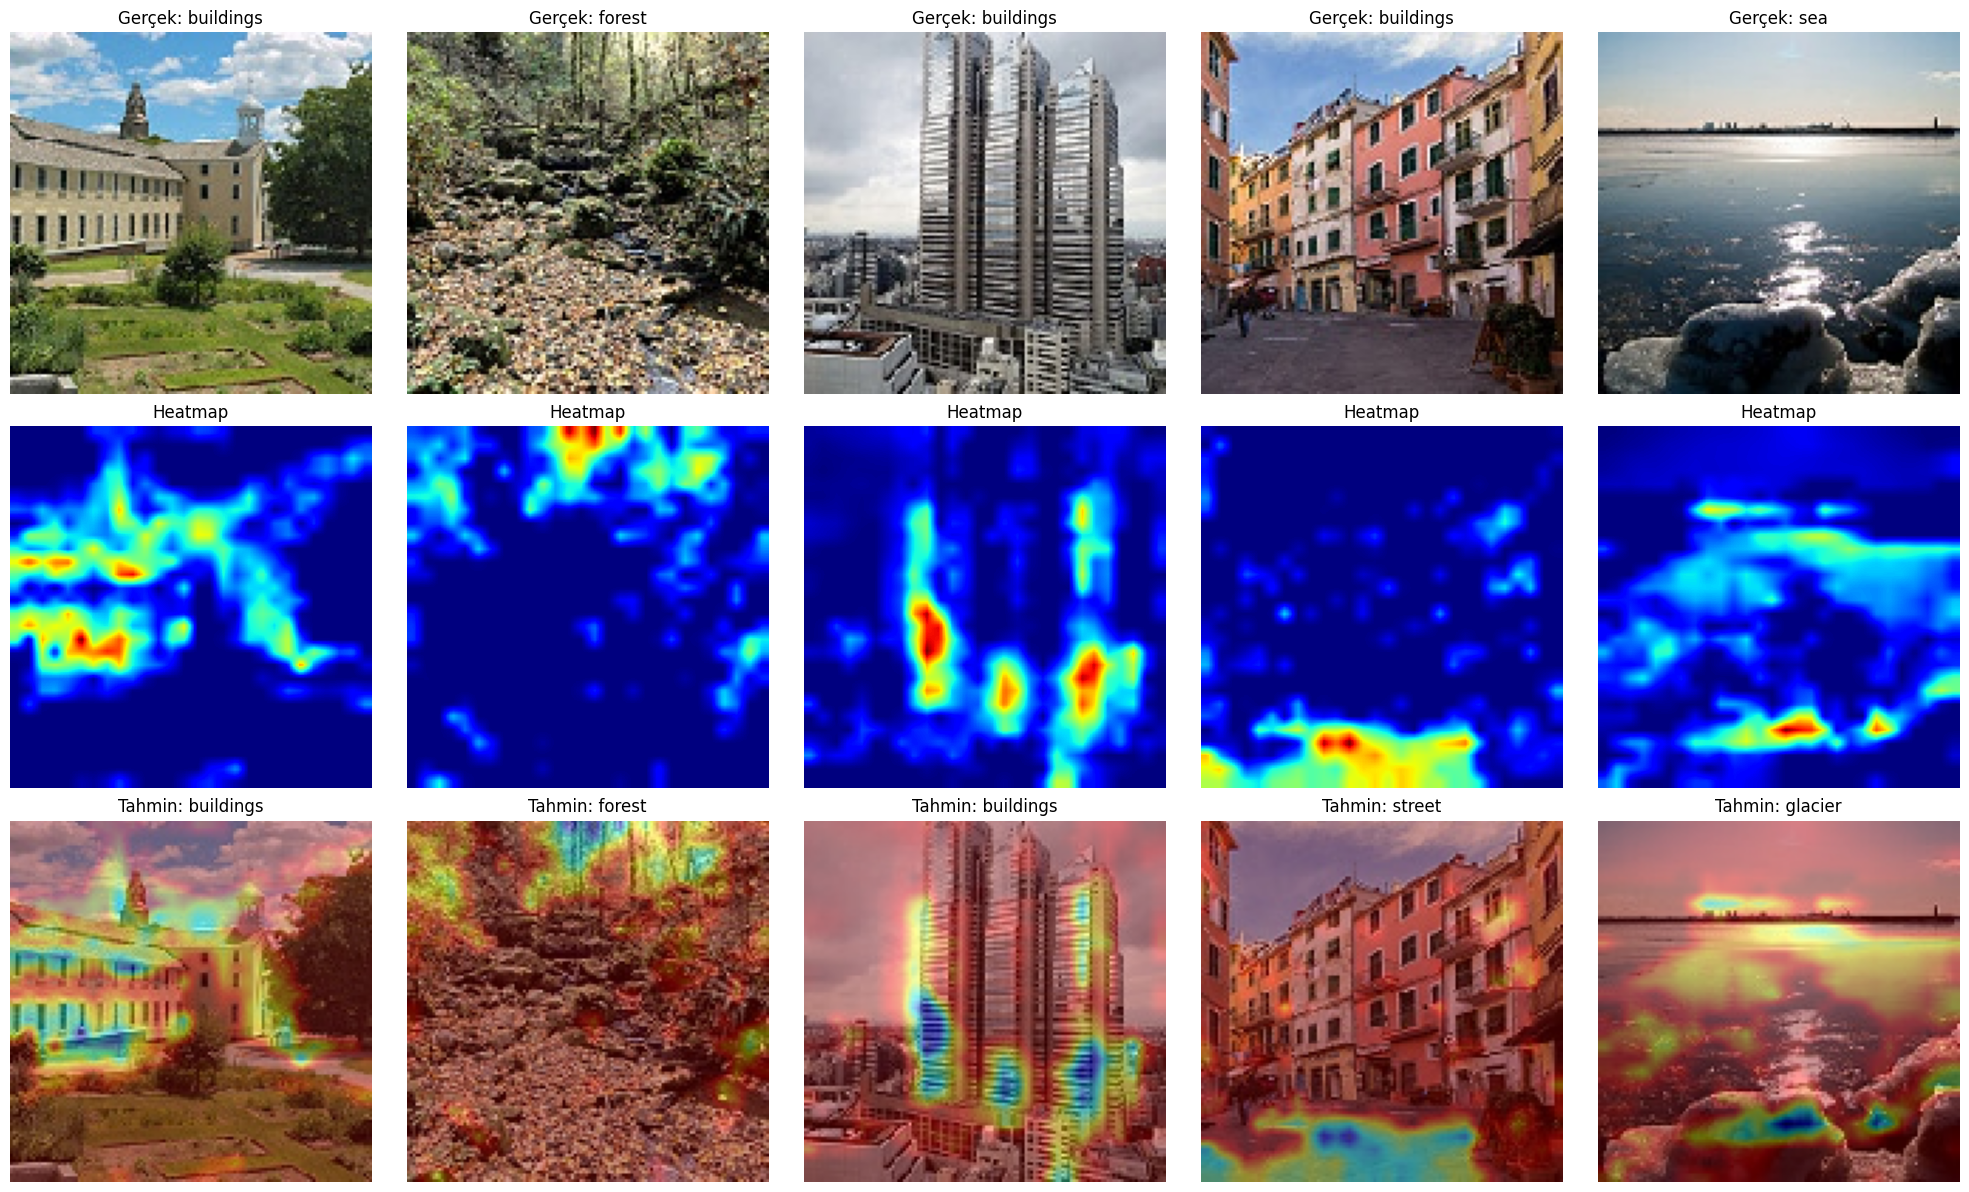


Grad-CAM başarıyla oluşturuldu!


In [12]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input

IMG_SIZE = 128
NUM_CLASSES = 6
MODEL_PATH = 'best_cnn_model.keras'
test_dir = '/kaggle/input/intel-image-classification/seg_test/seg_test' 

try:
    best_model_loaded = load_model(MODEL_PATH)
    original_weights = best_model_loaded.get_weights()
    print("Orijinal model yüklendi ve ağırlıklar alındı.")
except Exception as e:
    print(f"Hata: {e}")
    exit()

input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', name="last_conv_layer")(x) 
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling2D(2, 2)(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x) # Projenizdeki dropout oranlarına uyuldu
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

functional_model = Model(inputs=input_layer, outputs=output_layer)
functional_model.set_weights(original_weights)
print("Model ağırlıkları yüklendi.")

def make_gradcam_heatmap_functional(img_array, model, last_conv_layer_name):
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array, training=False)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

class_labels = ["buildings", "forest", "glacier", "mountain", "sea", "street"]
last_conv_layer_name = "last_conv_layer" 
num_samples_to_visualize = 5

plt.figure(figsize=(20, 12))

for i in range(num_samples_to_visualize):
    target_class = np.random.choice(class_labels)
    image_dir = os.path.join(test_dir, target_class)
    img_file = np.random.choice(os.listdir(image_dir))
    img_path = os.path.join(image_dir, img_file)
    
    original_image = tf.keras.utils.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    original_image = tf.keras.utils.img_to_array(original_image) / 255.0
    img_array_for_model = np.expand_dims(original_image, axis=0)
    
    try:
        heatmap = make_gradcam_heatmap_functional(img_array_for_model, functional_model, last_conv_layer_name)
    except Exception as e:
        print(f"Heatmap oluşturma hatası: {e}")
        continue
    
    img_uint8 = (original_image * 255).astype(np.uint8)
    heatmap_resized = cv2.resize(heatmap, (img_uint8.shape[1], img_uint8.shape[0]))
    heatmap_color = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_color, cv2.COLORMAP_JET)
    superimposed_image = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    prediction = functional_model.predict(img_array_for_model, verbose=0) 
    predicted_label = class_labels[np.argmax(prediction)]
    true_label = target_class

    plt.subplot(3, num_samples_to_visualize, i + 1)
    plt.imshow(original_image); plt.title(f"Gerçek: {true_label}"); plt.axis('off')

    plt.subplot(3, num_samples_to_visualize, i + num_samples_to_visualize + 1)
    plt.imshow(heatmap_resized, cmap='jet'); plt.title("Heatmap"); plt.axis('off')

    plt.subplot(3, num_samples_to_visualize, i + 2*num_samples_to_visualize + 1)
    plt.imshow(superimposed_image); plt.title(f"Tahmin: {predicted_label}"); plt.axis('off')

plt.tight_layout()
plt.show()

print("\nGrad-CAM başarıyla oluşturuldu!")